In [24]:
#Imports
# import matplotlib.pyplot as plt
# from matplotlib import gridspec
# import tensorflow as tf 
# from tensorflow.keras.preprocessing import image_dataset_from_directory
# import numpy as np
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers, callbacks
print(tf.__version__)


2.6.0


My First Visual Studio Code, Tensorflow, & Jupyter Notebook Project

Code copied from https://www.kaggle.com/ryanholbrook/custom-convnets

In [25]:

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')



# Load training and validation sets
ds_train_ = tf.keras.preprocessing.image_dataset_from_directory(
    './car_truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = tf.keras.preprocessing.image_dataset_from_directory(
    './car_truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 2000 files belonging to 2 classes.
Found 1909 files belonging to 2 classes.


Load Pretrained Base

In [26]:
pretrained_base = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=[128,128,3],
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
pretrained_base.trainable = False

Early Stopping

In [35]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

Attach Head

In [32]:




# Pretrained base model

# model = keras.Sequential([
#     pretrained_base,
#     layers.Flatten(),
#     layers.Dense(6, activation='relu'),
#     layers.Dense(1, activation='sigmoid'),
# ])

# Custom base  0.720796 val_binary_accuracy

model = keras.Sequential([

    # First Convolutional Block
    layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same',
                  # give the input dimensions in the first layer
                  # [height, width, color channels(RGB)]
                  input_shape=[128, 128, 3]),
    layers.MaxPool2D(),

    # Second Convolutional Block
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),

    # Third Convolutional Block
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),

    #Fourth Convolutional Block
    layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),

    # Classifier Head
    layers.Flatten(),
    layers.Dense(units=6, activation="relu"),
    layers.Dense(units=1, activation="sigmoid"),
])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 128, 128, 32)      2432      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 16, 256)      

Train

In [33]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,
    callbacks=[early_stopping], 
    verbose=1,
)

Epoch 1/30
32/32 [==============================] - 28s 876ms/step - loss: 0.6782 - binary_accuracy: 0.5750 - val_loss: 0.6767 - val_binary_accuracy: 0.5972
Epoch 2/30
32/32 [==============================] - 28s 865ms/step - loss: 0.6628 - binary_accuracy: 0.6120 - val_loss: 0.6642 - val_binary_accuracy: 0.6197
Epoch 3/30
32/32 [==============================] - 28s 875ms/step - loss: 0.6410 - binary_accuracy: 0.6290 - val_loss: 0.6353 - val_binary_accuracy: 0.6412
Epoch 4/30
32/32 [==============================] - 28s 886ms/step - loss: 0.6370 - binary_accuracy: 0.6395 - val_loss: 0.6428 - val_binary_accuracy: 0.6469
Epoch 5/30
32/32 [==============================] - 28s 879ms/step - loss: 0.6075 - binary_accuracy: 0.6825 - val_loss: 0.6175 - val_binary_accuracy: 0.6595
Epoch 6/30
32/32 [==============================] - 28s 880ms/step - loss: 0.5731 - binary_accuracy: 0.7010 - val_loss: 0.5809 - val_binary_accuracy: 0.6862
Epoch 7/30
32/32 [==============================] - 28s 87

0     0.563122
1     0.563122
2     0.563122
3     0.563122
4     0.563122
5     0.563122
6     0.563122
7     0.563122
8     0.563122
9     0.563122
10    0.563122
11    0.563122
12    0.563122
13    0.563122
14    0.563122
15    0.563122
16    0.563122
17    0.563122
18    0.563122
19    0.563122
20    0.563122
21    0.563122
22    0.563122
23    0.563122
24    0.563122
25    0.563122
26    0.563122
27    0.563122
28    0.563122
29    0.563122
Name: val_binary_accuracy, dtype: float64


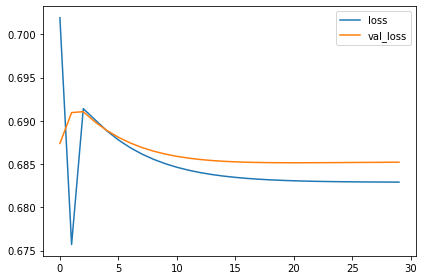

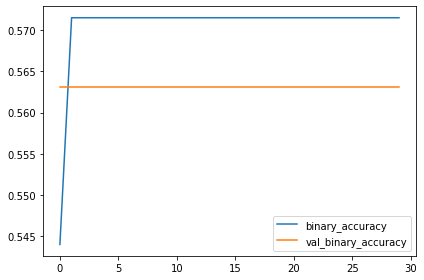

In [29]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();
print(history_frame.val_binary_accuracy)
